In [1]:
%%capture
!pip install audiomentations

In [2]:
import os
import sys

PROJECT_ROOT = os.path.abspath(os.path.join(
                  os.path.dirname("test-augmentation"), 
                  os.pardir)
)
sys.path.append(PROJECT_ROOT)

import torch
import torch.nn.functional as F
import torchaudio
import webrtcvad
import collections
import numpy as np
import math
import pandas as pd
import random
import IPython.display as ipd
import librosa.display
import librosa
import audiomentations
import matplotlib.pyplot as plt
import torchaudio.transforms as T
from torchaudio.functional import vad
from typing import List, Tuple, Dict, Union
from scipy.signal import butter, sosfilt, sosfilt_zi
from src.utils import create_propor_train_dataframe
from src.processing import read_audio
from src.data_augmentation import Denoiser, Mixup, SpecAugment, Specmix
from src.features import extract_melspectrogram, extract_mfcc

# Making sure the experiments are reproducible
seed = 2109
random.seed(seed)
np.random.seed(seed)
torch.cuda.manual_seed(seed)
os.environ["PYTHONHASHSEED"] = str(seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

In [3]:
def convert_to_numpy(audio: torch.Tensor) -> np.ndarray:
    return audio.detach().squeeze(0).numpy()

def convert_to_torch(audio: torch.Tensor) -> torch.Tensor:
    return torch.from_numpy(audio).unsqueeze(0)

In [4]:
propor_path = "/media/greca/HD/Datasets/PROPOR 2022/"
df = create_propor_train_dataframe(propor_path)
df.head()

,file,label,wav_file
0,/media/greca/HD/Datasets/PROPOR 2022/data_trai...,non-neutral-male,bpubdl02_segment247_non-neutral-male.wav
1,/media/greca/HD/Datasets/PROPOR 2022/data_trai...,neutral,bpubmn14_segment89_neutral.wav
2,/media/greca/HD/Datasets/PROPOR 2022/data_trai...,neutral,bfamdl26_segment93_neutral.wav
3,/media/greca/HD/Datasets/PROPOR 2022/data_trai...,neutral,bfammn27_segment275_neutral.wav
4,/media/greca/HD/Datasets/PROPOR 2022/data_trai...,neutral,bfamcv02_segment276_neutral.wav


In [5]:
audios = []
files = df["file"].tolist()
sample_rate = 16000

for file in files:
    audio, sr = read_audio(
        path=file,
        to_mono=True,
        sample_rate=sample_rate
    )
    
    audios.append(audio)

## Applying Low Pass Filter to remove noise (Audiomentation)

In [6]:
audio_test = convert_to_numpy(audios[0])
ipd.Audio(audio_test, rate=sample_rate)

In [7]:
transformer = audiomentations.LowPassFilter(
    min_rolloff=6,
    max_rolloff=6,
    p=1.0
)
audio_lpf = transformer(audio_test, sample_rate=sample_rate)
# audio_lpf = convert_to_numpy(audio_lpf)
ipd.Audio(audio_lpf, rate=sample_rate)

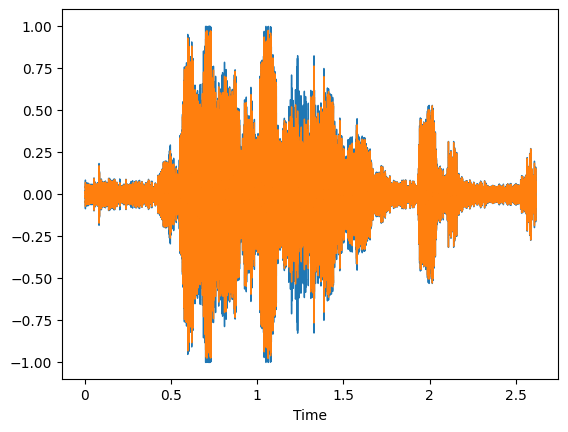

In [8]:
librosa.display.waveshow(audio_test, sr=sample_rate)
librosa.display.waveshow(audio_lpf, sr=sample_rate)

## Applying Low Pass Filter to remove noise (Butterworth Scipy)

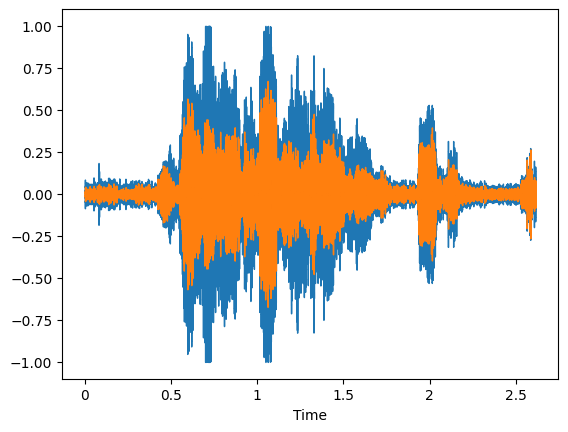

In [9]:
def convert_frequency_to_mel(f: float) -> float:
    """
    Convert f hertz to mels
    https://en.wikipedia.org/wiki/Mel_scale#Formula
    """
    return 2595.0 * math.log10(1.0 + f / 700.0)

def convert_mel_to_frequency(m: Union[float, np.array]) -> Union[float, np.array]:
    """
    Convert m mels to hertz
    https://en.wikipedia.org/wiki/Mel_scale#History_and_other_formulas
    """
    return 700.0 * (10 ** (m / 2595.0) - 1.0)

def butterworth_filter(
    signal: torch.Tensor,
    order: int,
    w: float,
    filter_type: str,
    sample_rate: int,
    analog: bool = False
):
    assert filter_type in ["lowpass", "low", "high", "highpass"]
    assert 0 < w <= sample_rate // 2
    
    signal = convert_to_numpy(signal)
    sos = butter(
        order,
        w,
        filter_type,
        analog=analog,
        output="sos",
        fs=sample_rate
    )
    processed_samples, _ = sosfilt(
        sos, signal, zi=sosfilt_zi(sos) * signal[0]
    )
    processed_samples = processed_samples.astype(np.float32)
    return convert_to_torch(processed_samples)

min_cutoff_freq = 150
max_cutoff_freq = sample_rate // 2

cutoff_mel = np.random.uniform(
    low=convert_frequency_to_mel(min_cutoff_freq),
    high=convert_frequency_to_mel(max_cutoff_freq),
)
w = convert_mel_to_frequency(cutoff_mel)
processed_samples = butterworth_filter(
    audios[0],
    2,
    400,
    "low",
    sample_rate
)

audio_numpy = convert_to_numpy(audios[0])
processed_samples = convert_to_numpy(processed_samples)

librosa.display.waveshow(audio_numpy, sr=sample_rate)
librosa.display.waveshow(processed_samples, sr=sample_rate)
ipd.Audio(processed_samples, rate=sample_rate)

## Applying High Pass Filter to remove noise (Audiomentation)

In [10]:
audio_test = convert_to_numpy(audios[0])
ipd.Audio(audio_test, rate=sample_rate)

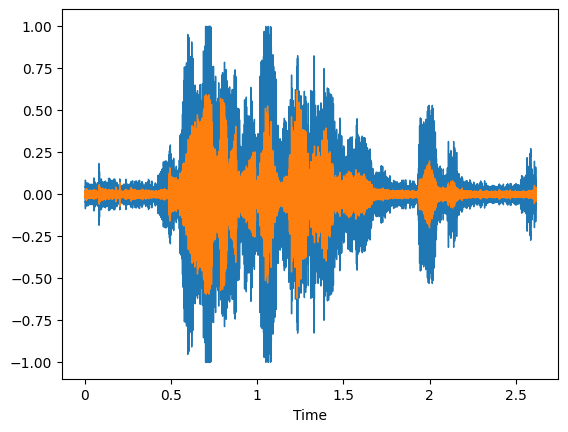

In [11]:
transformer = audiomentations.HighPassFilter(
    min_rolloff=6,
    max_rolloff=6,
    p=1.0
)
audio_lpf = transformer(audio_test, sample_rate=sample_rate)
# audio_lpf = convert_to_numpy(audio_lpf)

librosa.display.waveshow(audio_test, sr=sample_rate)
librosa.display.waveshow(audio_lpf, sr=sample_rate)
ipd.Audio(audio_lpf, rate=sample_rate)

## Applying High Pass Filter to remove noise (Butterworth Scipy)

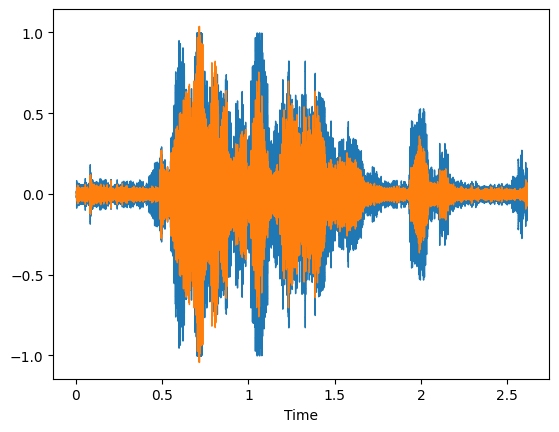

In [12]:
min_cutoff_freq = 20
max_cutoff_freq = 2400

cutoff_mel = np.random.uniform(
    low=convert_frequency_to_mel(min_cutoff_freq),
    high=convert_frequency_to_mel(max_cutoff_freq),
)
w = convert_mel_to_frequency(cutoff_mel)
processed_samples = butterworth_filter(
    audios[0],
    2,
    700,
    "high",
    sample_rate
)

audio_numpy = convert_to_numpy(audios[0])
processed_samples = convert_to_numpy(processed_samples)

librosa.display.waveshow(audio_numpy, sr=sample_rate)
librosa.display.waveshow(processed_samples, sr=sample_rate)
ipd.Audio(processed_samples, rate=sample_rate)

## Applying High Pass and Low Pass Filter to remove noise (Butterworth Scipy)

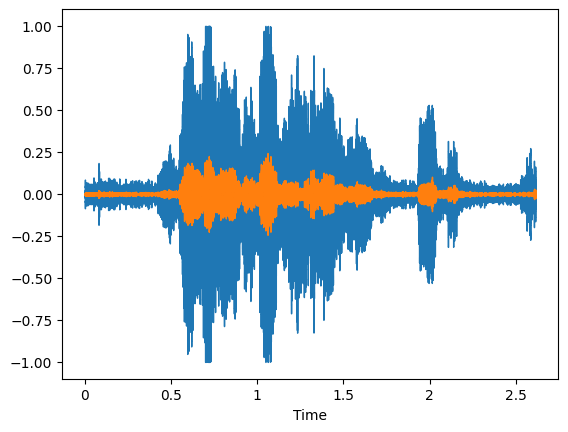

In [13]:
processed_samples = butterworth_filter(
    audios[0],
    2,
    700,
    "high",
    sample_rate
)
processed_samples = butterworth_filter(
    processed_samples,
    2,
    400,
    "low",
    sample_rate
)

audio_numpy = convert_to_numpy(audios[0])
processed_samples = convert_to_numpy(processed_samples)

librosa.display.waveshow(audio_numpy, sr=sample_rate)
librosa.display.waveshow(processed_samples, sr=sample_rate)
ipd.Audio(processed_samples, rate=sample_rate)

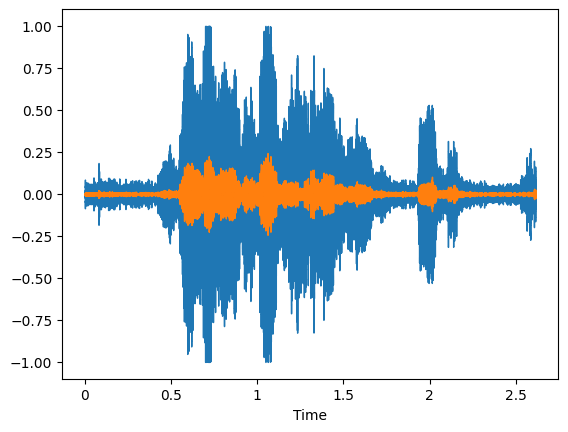

In [14]:
denoise = Denoiser(
    p=1,
    filters=["low_pass", "high_pass"],
    sample_rate=16000
)
processed_samples = denoise(audios[0])

# audio_numpy = convert_to_numpy(audios[0])
# processed_samples = convert_to_numpy(processed_samples)

assert not torch.all(torch.eq(audios[0], processed_samples))

librosa.display.waveshow(audio_numpy, sr=sample_rate)
librosa.display.waveshow(convert_to_numpy(processed_samples), sr=sample_rate)

## Applying SpecAugment (Torch)

In [15]:
def plot_spectrogram(spec, title=None, ylabel="freq_bin", aspect="auto", xmax=None):
    fig, axs = plt.subplots(1, 1)
    axs.set_title(title or "Spectrogram (db)")
    axs.set_ylabel(ylabel)
    axs.set_xlabel("frame")
    im = axs.imshow(librosa.power_to_db(spec), origin="lower", aspect=aspect)
    if xmax:
        axs.set_xlim((0, xmax))
    fig.colorbar(im, ax=axs)
    plt.show(block=False)

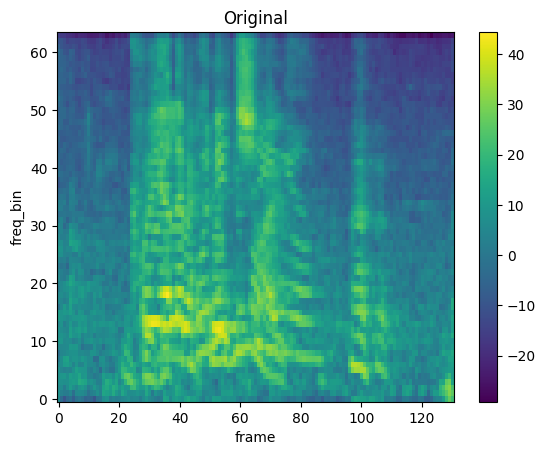

In [16]:
spec = extract_melspectrogram(
    audio=audios[0],
    n_fft=1024,
    hop_length=320,
    n_mels=64,
    sample_rate=16000
)
plot_spectrogram(spec[0], title="Original")

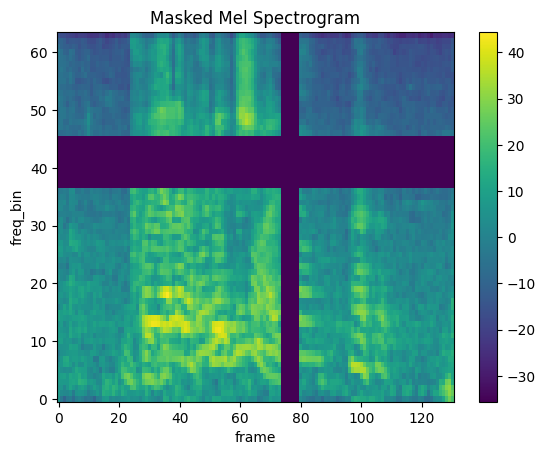

In [17]:
spec_augment = SpecAugment(
    p=1,
    transformations=["time_mask", "frequency_mask"],
    mask_samples=10,
    feature="mel_spectrogram"
)
masked_spec = spec_augment(spec)
plot_spectrogram(masked_spec[0], title="Masked Mel Spectrogram")

## Mixup Data Augmentation

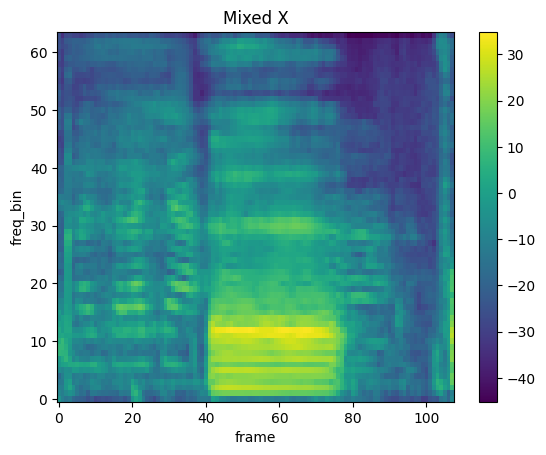

In [18]:
spec1 = extract_melspectrogram(
    audio=audios[1],
    n_fft=1024,
    hop_length=320,
    n_mels=64,
    sample_rate=16000
)

spec2 = extract_melspectrogram(
    audio=audios[2],
    n_fft=1024,
    hop_length=320,
    n_mels=64,
    sample_rate=16000
)

x = torch.concat((spec1[:, :, :108], spec2[:, :, :108]))
y = torch.Tensor([[0, 0, 1], [0, 1, 0]])
x = x.unsqueeze(1)

mixup = Mixup()
mixed_x, mixed_y = mixup(x, y)

assert not (torch.all(torch.eq(mixed_x[0], x[0])) and torch.all(torch.eq(mixed_x[1], x[1])))
assert not (torch.all(torch.eq(mixed_y[0], y[0])) and torch.all(torch.eq(mixed_y[1], y[1])))

plot_spectrogram(mixed_x[0].squeeze(), title="Mixed X")

In [19]:
mixed_y

tensor([[0.0000, 0.5894, 0.4106],
        [0.0000, 0.4106, 0.5894]])

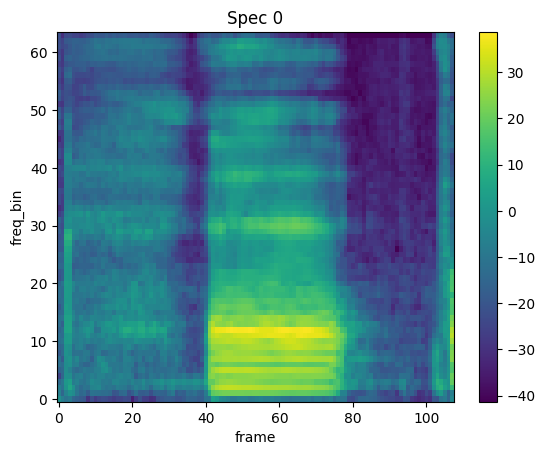

In [20]:
plot_spectrogram(x[0].squeeze(), title="Spec 0")

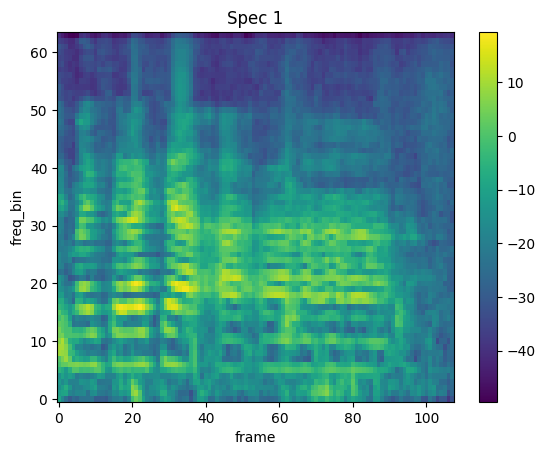

In [21]:
plot_spectrogram(x[1].squeeze(), title="Spec 1")

## Specmix Data Augmentation

torch.Size([2, 1, 64, 108])
torch.Size([1, 64, 108])


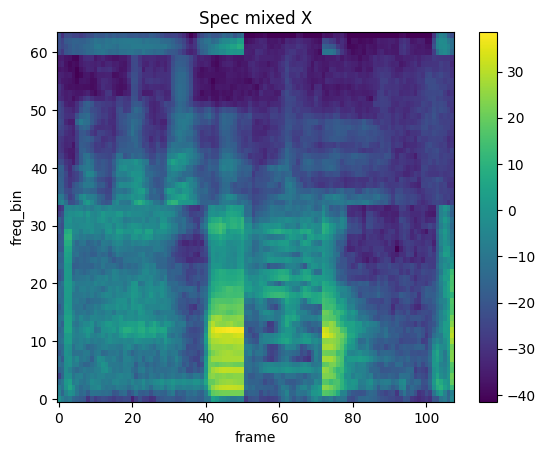

In [33]:
specmix = Specmix(
    min_band_size=20,
    max_band_size=30,
    max_frequency_bands=4,
    max_time_bands=3,
)

specmixed_x, specmixed_y = specmix(x, y)

assert not (torch.all(torch.eq(specmixed_x[0], x[0])) and torch.all(torch.eq(specmixed_x[1], x[1])))
assert not (torch.all(torch.eq(specmixed_y[0], y[0])) and torch.all(torch.eq(specmixed_y[1], y[1])))

plot_spectrogram(specmixed_x[0].squeeze(), title="Spec mixed X")

In [34]:
specmixed_y

tensor([[0.0000, 0.5217, 0.4783],
        [0.0000, 0.4783, 0.5217]])